https://docs.pymc.io/notebooks/rugby_analytics.html

https://mc-stan.org/users/documentation/case-studies/rstan_workflow.html

Original Author: Peadar Coyle
peadarcoyle@gmail.com

In [143]:
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

In [2]:
def scrape_epl(url):
    print(url)
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'lxml')
    table = soup.find('table', 'wikitable plainrowheaders')
    
    rows = table.find_all('tr')

    d = []
    for row in rows:
        data = row.find_all('td')

        d.append([element.text.strip('\n') for element in data])
    assert len(d) == len(rows)
        
    headers = [r for r in table.find_all('th')]
    headers = [h.text.strip('\n') for h in headers]
    #import pdb; pdb.set_trace()
    headers = headers[1 + int((len(headers) - 1) / 2):]
    
    data = np.concatenate([np.array(data) for data in d]).reshape(len(data), -1)
    
    data = pd.DataFrame(data, columns=headers, index=headers)
    
    output = []

    for row in range(data.shape[0]):
        for col in range(data.shape[1]):

            if row == col:
                pass
            else:
                d = data.iloc[row, col]
                output.append(
                    {'home-team': data.index[row], 
                     'away-team': data.columns[col], 
                     'home-score': d.split('–')[0], 
                     'away-score': d.split('–')[1],
                     'season': url.split('/')[-1][:4]}
                )
                
    return pd.DataFrame(output)


date_range = pd.date_range(start='01-01-1992', end='01-01-2014', freq='1y')
years = [date.year for date in date_range]
urls = []
for idx, year in enumerate(years[1:], 1):
    urls.append(
        'https://en.wikipedia.org/wiki/{}–{}_FA_Premier_League'.format(str(years[idx-1]), str(year)[-2:])
    )
    
data = []
for url in urls:
    data.append(scrape_epl(url))
    
data = pd.concat(data, axis=0)

https://en.wikipedia.org/wiki/1992–93_FA_Premier_League
https://en.wikipedia.org/wiki/1993–94_FA_Premier_League
https://en.wikipedia.org/wiki/1994–95_FA_Premier_League
https://en.wikipedia.org/wiki/1995–96_FA_Premier_League
https://en.wikipedia.org/wiki/1996–97_FA_Premier_League
https://en.wikipedia.org/wiki/1997–98_FA_Premier_League
https://en.wikipedia.org/wiki/1998–99_FA_Premier_League
https://en.wikipedia.org/wiki/1999–00_FA_Premier_League
https://en.wikipedia.org/wiki/2000–01_FA_Premier_League
https://en.wikipedia.org/wiki/2001–02_FA_Premier_League
https://en.wikipedia.org/wiki/2002–03_FA_Premier_League
https://en.wikipedia.org/wiki/2003–04_FA_Premier_League
https://en.wikipedia.org/wiki/2004–05_FA_Premier_League
https://en.wikipedia.org/wiki/2005–06_FA_Premier_League
https://en.wikipedia.org/wiki/2006–07_FA_Premier_League
https://en.wikipedia.org/wiki/2007–08_FA_Premier_League
https://en.wikipedia.org/wiki/2008–09_FA_Premier_League
https://en.wikipedia.org/wiki/2009–10_FA_Premier

Add score difference:

In [3]:
data.loc[:, 'home-score'] = data.loc[:, 'home-score'].astype(int)
data.loc[:, 'away-score'] = data.loc[:, 'away-score'].astype(int)

In [4]:
data.loc[:, 'abs-difference'] = np.abs(data.loc[:, 'home-score'] - data.loc[:, 'away-score'])
data.loc[:, 'difference'] = data.loc[:, 'home-score'] - data.loc[:, 'away-score']

In [5]:
_ = data.groupby('season')['abs-difference'].mean().plot(
    kind='bar', title='Average magnitude of scores difference Six Nations', 
    yerr=data.groupby('season')['abs-difference'].std()
).set_ylabel('Average (abs) point difference')


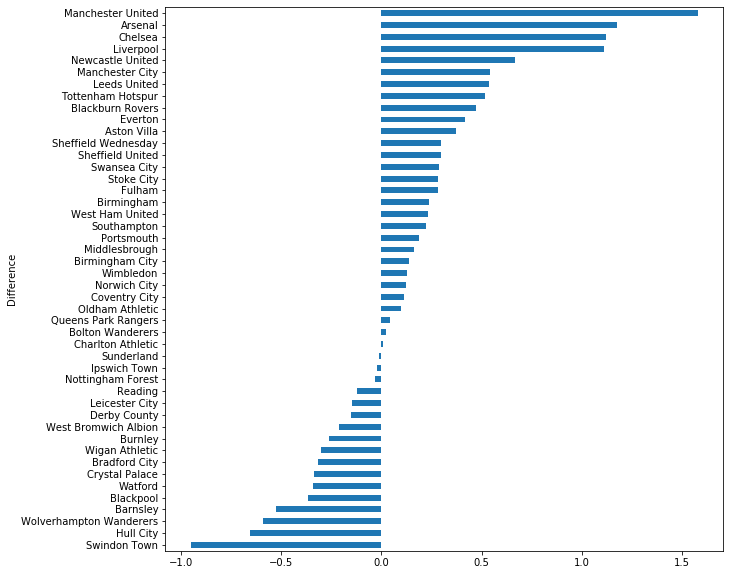

In [6]:
#data.pivot_table('difference', 'home_team', 'season')

_ = data.pivot_table('difference', 'home-team').sort_values(by='difference').rename_axis("Home-Team").plot(kind='barh', rot=0, legend=False, figsize=(10, 10)).set_ylabel('Difference')

## Poisson distribution

TODO

## Making the model

Scoring as Poisson distributed.  Sample our goals at home and away for game $g$
- $g$ games per season
- $home_g$ game $g$ at home
- $away_g$ game $g$ away

$$home_g \sim Poisson(\theta_h)$$

$$away_g \sim Poisson(\theta_a)$$

Model the team specific effects for $t$ teams

$$a_t \sim Normal(\mu_t, \sigma_t)$$

$$d_t \sim Normal(\mu_t, \sigma_t)$$

Model the Poisson parameters using a log-linear random effect model 
- $\text{home}$ advantage for the home team (constant for all teams)

$$\log(\theta_h) = \text{home} + a_{home_{g}} + d_{away_{g}}$$

$$\log(\theta_a) = a_{away_{g}} + d_{home_{g}}$$

In [7]:
grp = data.groupby('away-team')
att_initial = np.log(grp.mean())

grp = data.groupby('home-team')
def_initial = np.log(grp.mean())

teams = def_initial.index
num_teams = len(teams)

assert (att_initial.index == def_initial.index).all()

/Users/adam/.pyenv/versions/3.6.8/envs/teach/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/adam/.pyenv/versions/3.6.8/envs/teach/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


In [8]:
data.head(2)

,home-team,away-team,home-score,away-score,season,abs-difference,difference
0,Arsenal,Aston Villa,0,1,1992,1,-1
1,Arsenal,Blackburn Rovers,0,1,1992,1,-1


In [9]:
mapper = {name: idx for idx, name in enumerate(teams)}

In [10]:
data.loc[:, 'home-idx'] = data.loc[:, 'home-team'].replace(mapper)
data.loc[:, 'away-idx'] = data.loc[:, 'away-team'].replace(mapper)

In [11]:
home_team = data.loc[:, 'home-idx'].values
away_team = data.loc[:, 'away-idx'].values

observed_home_goals = data.loc[:, 'home-score'].values
observed_away_goals = data.loc[:, 'away-score'].values

In [12]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Flat('intercept')

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_goals', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_goals', mu=away_theta, observed=observed_away_goals)

In [15]:
with model:
    trace = pm.sample(5000, tune=1000, cores=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 6 chains: 100%|██████████| 36000/36000 [02:36<00:00, 230.45draws/s]


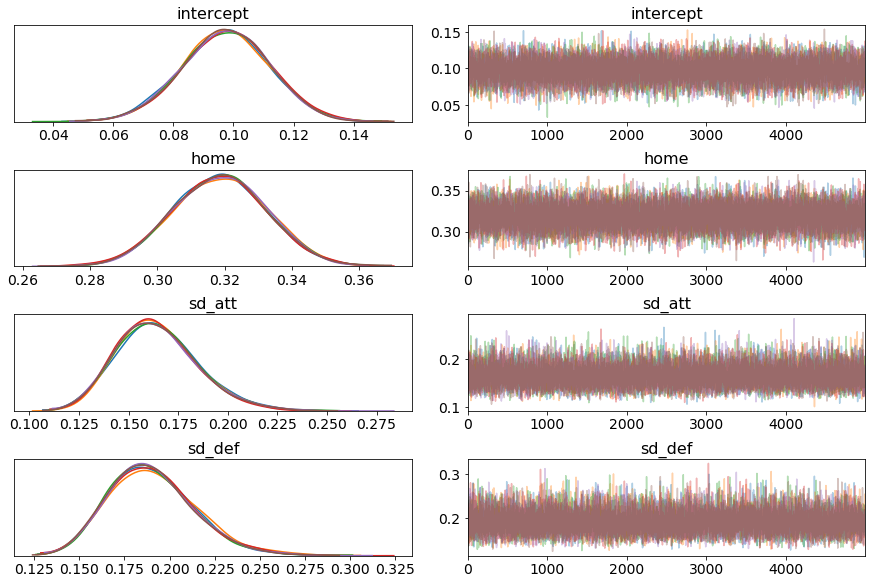

In [16]:
pm.traceplot(trace, var_names=['intercept', 'home', 'sd_att', 'sd_def']);

Let us apply good statistical workflow practices and look at the various evaluation metrics to see if our NUTS sampler converged:

Text(0.5, 1.0, 'BFMI = 1.0258657527459405\nGelman-Rubin = 1.000494379642081')

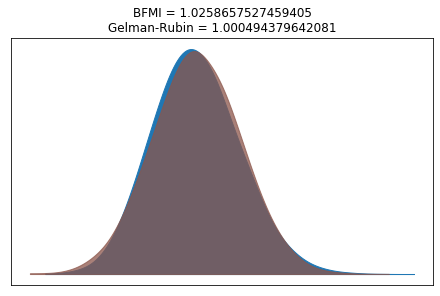

In [19]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

pm.energyplot(trace, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr))

TODO - Our model has converged well and the Gelman-Rubin statistic looks good.

## Results

In [27]:
# highest posterior density (HPD)
pm.stats.hpd(trace['atts'])

array([[ 0.29937908,  0.40844886],
       [-0.01774597,  0.10768942],
       [-0.32876202,  0.11434763],
       [-0.17775005,  0.16043385],
       [-0.30963388, -0.05302383],
       [ 0.03469502,  0.16500781],
       [-0.10094601,  0.31220196],
       [-0.10325997,  0.05591381],
       [-0.37169175, -0.00382679],
       [-0.26749274,  0.16146615],
       [-0.14615051,  0.05188327],
       [ 0.25556892,  0.36663127],
       [-0.17805056,  0.01179542],
       [-0.28641534, -0.01387228],
       [-0.24267808, -0.02406307],
       [-0.01020956,  0.11491548],
       [-0.11225964,  0.05417518],
       [-0.33425905,  0.02367412],
       [-0.20798109,  0.03607185],
       [ 0.04843253,  0.20342707],
       [-0.12809343,  0.06993107],
       [ 0.21898009,  0.33209936],
       [ 0.04023755,  0.17567275],
       [ 0.43363337,  0.53783155],
       [-0.10256245,  0.05264311],
       [ 0.10486293,  0.22853186],
       [-0.07403844,  0.13828473],
       [-0.14130431,  0.09544537],
       [-0.13901808,

In [31]:
pm.stats.quantiles(trace['atts'])[50]

array([ 0.35305435,  0.04427408, -0.10140815, -0.00961456, -0.18165198,
        0.09988355,  0.10825869, -0.02153872, -0.18679584, -0.04988709,
       -0.04526326,  0.31117249, -0.08400023, -0.14582119, -0.13444637,
        0.0518357 , -0.0297967 , -0.15055042, -0.08362895,  0.12409789,
       -0.03094274,  0.27520688,  0.10827179,  0.48718268, -0.02468217,
        0.1677103 ,  0.0323641 , -0.0203871 ,  0.0264928 , -0.07700417,
        0.02867181,  0.00153905, -0.11115463,  0.07195333, -0.00098479,
       -0.1733071 , -0.15230335, -0.00745002, -0.03838184,  0.15196126,
       -0.22301837, -0.08630547, -0.01735042, -0.12651603,  0.01552815,
       -0.12223135])

In [40]:
medians = pd.DataFrame(
    {'median-atts': pm.stats.quantiles(trace['atts'])[50], 
     'median-defs': pm.stats.quantiles(trace['defs'])[50]}, 
    index=teams
)

medians.sort_values(by='median-atts', ascending=False).head(6)

,median-atts,median-defs
home-team,,
Manchester United,0.487183,-0.457872
Arsenal,0.353054,-0.401251
Chelsea,0.311172,-0.371560
Liverpool,0.275207,-0.354317
Newcastle United,0.167710,-0.088594
Tottenham Hotspur,0.151961,-0.080352


In [42]:
medians.sort_values(by='median-defs', ascending=True).head(6)

,median-atts,median-defs
home-team,,
Manchester United,0.487183,-0.457872
Arsenal,0.353054,-0.401251
Chelsea,0.311172,-0.371560
Liverpool,0.275207,-0.354317
Leeds United,0.124098,-0.155725
Aston Villa,0.044274,-0.155372


https://en.wikipedia.org/wiki/Credible_interval

In [174]:
hpd = pd.DataFrame(
    {'low': pm.stats.hpd(trace['atts'])[:, 0],
     'high': pm.stats.hpd(trace['atts'])[:, 1],
     'hpd_median': pm.stats.quantiles(trace['atts'])[50]},
    index=teams
)

hpd['relative-lower'] = hpd.hpd_median - hpd.low
hpd['relative-upper'] = hpd.high - hpd.hpd_median
hpd = hpd.sort_values(by='hpd_median')
hpd['x'] = np.arange(hpd.shape[0])

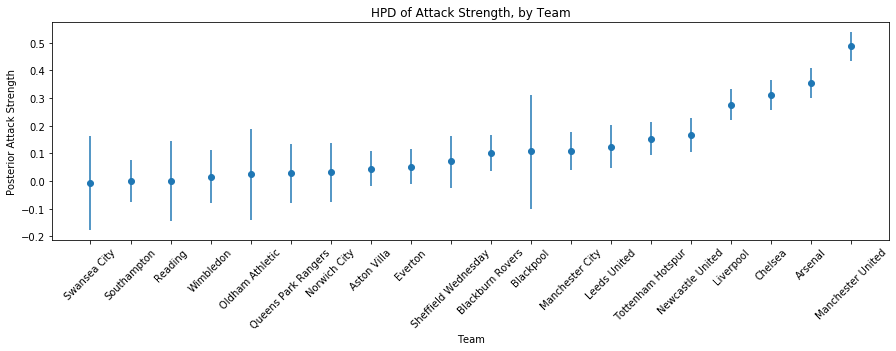

In [175]:
fig, axs = plt.subplots(figsize=(15,4))
hpd = hpd.iloc[-20:, :]
axs.errorbar(hpd.x, hpd.hpd_median,
             yerr=(hpd[['relative-lower', 'relative-upper']].values).T,
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
axs.set_xticks(hpd.x)
_ = axs.set_xticklabels(hpd.index.values, rotation=45)

This is one of the powerful things about Bayesian modelling, we can have uncertainty quantification of some of our estimates. We’ve got a Bayesian credible interval for the attack strength of different teams.

## Generating new data

In [43]:
with model:
    pp_trace = pm.sample_posterior_predictive(trace)

100%|██████████| 30000/30000 [01:15<00:00, 399.86it/s]


In [48]:
pp_trace['home_points'].shape

(30000, 8226)

In [100]:
home_sim = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * home_won
    for i, home_won in enumerate(pp_trace['home_points'] > pp_trace['away_points'])
})

home_sim = home_sim.reset_index(drop=True)

In [101]:
home_sim.shape

(8226, 30000)

In [102]:
data = data.reset_index(drop=True)

In [103]:
home_sim = pd.concat([data.loc[:, 'home-team'], home_sim], axis=1)

home_sim.head()

,home-team,sim_points_0,sim_points_1,sim_points_2,sim_points_3,sim_points_4,sim_points_5,sim_points_6,sim_points_7,sim_points_8,sim_points_9,sim_points_10,sim_points_11,sim_points_12,sim_points_13,sim_points_14,sim_points_15,sim_points_16,sim_points_17,sim_points_18,sim_points_19,sim_points_20,sim_points_21,sim_points_22,sim_points_23,sim_points_24,sim_points_25,sim_points_26,sim_points_27,sim_points_28,sim_points_29,sim_points_30,sim_points_31,sim_points_32,sim_points_33,sim_points_34,sim_points_35,sim_points_36,sim_points_37,sim_points_38,sim_points_39,sim_points_40,sim_points_41,sim_points_42,sim_points_43,sim_points_44,sim_points_45,sim_points_46,sim_points_47,sim_points_48,sim_points_49,sim_points_50,sim_points_51,sim_points_52,sim_points_53,sim_points_54,sim_points_55,sim_points_56,sim_points_57,sim_points_58,sim_points_59,sim_points_60,sim_points_61,sim_points_62,sim_points_63,sim_points_64,sim_points_65,sim_points_66,sim_points_67,sim_points_68,sim_points_69,sim_points_70,sim_points_71,sim_points_72,sim_points_73,sim_points_74,sim_points_75,sim_points_76,sim_points_77,sim_points_78,sim_points_79,sim_points_80,sim_points_81,sim_points_82,sim_points_83,sim_points_84,sim_points_85,sim_points_86,sim_points_87,sim_points_88,sim_points_89,sim_points_90,sim_points_91,sim_points_92,sim_points_93,sim_points_94,sim_points_95,sim_points_96,sim_points_97,sim_points_98,sim_points_99,sim_points_100,sim_points_101,sim_points_102,sim_points_103,sim_points_104,sim_points_105,sim_points_106,sim_points_107,sim_points_108,sim_points_109,sim_points_110,sim_points_111,sim_points_112,sim_points_113,sim_points_114,sim_points_115,sim_points_116,sim_points_117,sim_points_118,sim_points_119,sim_points_120,sim_points_121,sim_points_122,sim_points_123,sim_points_124,sim_points_125,sim_points_126,sim_points_127,sim_points_128,sim_points_129,sim_points_130,sim_points_131,sim_points_132,sim_points_133,sim_points_134,sim_points_135,sim_points_136,sim_points_137,sim_points_138,sim_points_139,sim_points_140,sim_points_141,sim_points_142,sim_points_143,sim_points_144,sim_points_145,sim_points_146,sim_points_147,sim_points_148,sim_points_149,sim_points_150,sim_points_151,sim_points_152,sim_points_153,sim_points_154,sim_points_155,sim_points_156,sim_points_157,sim_points_158,sim_points_159,sim_points_160,sim_points_161,sim_points_162,sim_points_163,sim_points_164,sim_points_165,sim_points_166,sim_points_167,sim_points_168,sim_points_169,sim_points_170,sim_points_171,sim_points_172,sim_points_173,sim_points_174,sim_points_175,sim_points_176,sim_points_177,sim_points_178,sim_points_179,sim_points_180,sim_points_181,sim_points_182,sim_points_183,sim_points_184,sim_points_185,sim_points_186,sim_points_187,sim_points_188,sim_points_189,sim_points_190,sim_points_191,sim_points_192,sim_points_193,sim_points_194,sim_points_195,sim_points_196,sim_points_197,sim_points_198,sim_points_199,sim_points_200,sim_points_201,sim_points_202,sim_points_203,sim_points_204,sim_points_205,sim_points_206,sim_points_207,sim_points_208,sim_points_209,sim_points_210,sim_points_211,sim_points_212,sim_points_213,sim_points_214,sim_points_215,sim_points_216,sim_points_217,sim_points_218,sim_points_219,sim_points_220,sim_points_221,sim_points_222,sim_points_223,sim_points_224,sim_points_225,sim_points_226,sim_points_227,sim_points_228,sim_points_229,sim_points_230,sim_points_231,sim_points_232,sim_points_233,sim_points_234,sim_points_235,sim_points_236,sim_points_237,sim_points_238,sim_points_239,sim_points_240,sim_points_241,sim_points_242,sim_points_243,sim_points_244,sim_points_245,sim_points_246,sim_points_247,sim_points_248,...,sim_points_29750,sim_points_29751,sim_points_29752,sim_points_29753,sim_points_29754,sim_points_29755,sim_points_29756,sim_points_29757,sim_points_29758,sim_points_29759,sim_points_29760,sim_points_29761,sim_points_29762,sim_points_29763,sim_points_29764,sim_points_29765,sim_points_29766,sim_points_29767,sim_points_29768,sim_points_29769,sim_points_29770,sim

In [107]:
away_sim = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * away_won
    for i, away_won in enumerate(pp_trace['home_points'] < pp_trace['away_points'])
})

away_sim = away_sim.reset_index(drop=True)

away_sim = pd.concat([data.loc[:, 'away-team'], away_sim], axis=1)

away_sim.head()

,away-team,sim_points_0,sim_points_1,sim_points_2,sim_points_3,sim_points_4,sim_points_5,sim_points_6,sim_points_7,sim_points_8,sim_points_9,sim_points_10,sim_points_11,sim_points_12,sim_points_13,sim_points_14,sim_points_15,sim_points_16,sim_points_17,sim_points_18,sim_points_19,sim_points_20,sim_points_21,sim_points_22,sim_points_23,sim_points_24,sim_points_25,sim_points_26,sim_points_27,sim_points_28,sim_points_29,sim_points_30,sim_points_31,sim_points_32,sim_points_33,sim_points_34,sim_points_35,sim_points_36,sim_points_37,sim_points_38,sim_points_39,sim_points_40,sim_points_41,sim_points_42,sim_points_43,sim_points_44,sim_points_45,sim_points_46,sim_points_47,sim_points_48,sim_points_49,sim_points_50,sim_points_51,sim_points_52,sim_points_53,sim_points_54,sim_points_55,sim_points_56,sim_points_57,sim_points_58,sim_points_59,sim_points_60,sim_points_61,sim_points_62,sim_points_63,sim_points_64,sim_points_65,sim_points_66,sim_points_67,sim_points_68,sim_points_69,sim_points_70,sim_points_71,sim_points_72,sim_points_73,sim_points_74,sim_points_75,sim_points_76,sim_points_77,sim_points_78,sim_points_79,sim_points_80,sim_points_81,sim_points_82,sim_points_83,sim_points_84,sim_points_85,sim_points_86,sim_points_87,sim_points_88,sim_points_89,sim_points_90,sim_points_91,sim_points_92,sim_points_93,sim_points_94,sim_points_95,sim_points_96,sim_points_97,sim_points_98,sim_points_99,sim_points_100,sim_points_101,sim_points_102,sim_points_103,sim_points_104,sim_points_105,sim_points_106,sim_points_107,sim_points_108,sim_points_109,sim_points_110,sim_points_111,sim_points_112,sim_points_113,sim_points_114,sim_points_115,sim_points_116,sim_points_117,sim_points_118,sim_points_119,sim_points_120,sim_points_121,sim_points_122,sim_points_123,sim_points_124,sim_points_125,sim_points_126,sim_points_127,sim_points_128,sim_points_129,sim_points_130,sim_points_131,sim_points_132,sim_points_133,sim_points_134,sim_points_135,sim_points_136,sim_points_137,sim_points_138,sim_points_139,sim_points_140,sim_points_141,sim_points_142,sim_points_143,sim_points_144,sim_points_145,sim_points_146,sim_points_147,sim_points_148,sim_points_149,sim_points_150,sim_points_151,sim_points_152,sim_points_153,sim_points_154,sim_points_155,sim_points_156,sim_points_157,sim_points_158,sim_points_159,sim_points_160,sim_points_161,sim_points_162,sim_points_163,sim_points_164,sim_points_165,sim_points_166,sim_points_167,sim_points_168,sim_points_169,sim_points_170,sim_points_171,sim_points_172,sim_points_173,sim_points_174,sim_points_175,sim_points_176,sim_points_177,sim_points_178,sim_points_179,sim_points_180,sim_points_181,sim_points_182,sim_points_183,sim_points_184,sim_points_185,sim_points_186,sim_points_187,sim_points_188,sim_points_189,sim_points_190,sim_points_191,sim_points_192,sim_points_193,sim_points_194,sim_points_195,sim_points_196,sim_points_197,sim_points_198,sim_points_199,sim_points_200,sim_points_201,sim_points_202,sim_points_203,sim_points_204,sim_points_205,sim_points_206,sim_points_207,sim_points_208,sim_points_209,sim_points_210,sim_points_211,sim_points_212,sim_points_213,sim_points_214,sim_points_215,sim_points_216,sim_points_217,sim_points_218,sim_points_219,sim_points_220,sim_points_221,sim_points_222,sim_points_223,sim_points_224,sim_points_225,sim_points_226,sim_points_227,sim_points_228,sim_points_229,sim_points_230,sim_points_231,sim_points_232,sim_points_233,sim_points_234,sim_points_235,sim_points_236,sim_points_237,sim_points_238,sim_points_239,sim_points_240,sim_points_241,sim_points_242,sim_points_243,sim_points_244,sim_points_245,sim_points_246,sim_points_247,sim_points_248,...,sim_points_29750,sim_points_29751,sim_points_29752,sim_points_29753,sim_points_29754,sim_points_29755,sim_points_29756,sim_points_29757,sim_points_29758,sim_points_29759,sim_points_29760,sim_points_29761,sim_points_29762,sim_points_29763,sim_points_29764,sim_points_29765,sim_points_29766,sim_points_29767,sim_points_29768,sim_points_29769,sim_points_29770,sim

In [121]:
out = (
    home_sim.groupby('home-team').sum()
    .add(away_sim.groupby('away-team').sum())
    .rank(ascending=False, method='min', axis=0)
    .reset_index()
    .melt(id_vars='home-team', value_name='rank')
    .groupby('home-team')
    ['rank']
    .value_counts()
    .unstack(level='rank')
    .fillna(0)
    .div(1000)
)

In [127]:
out.iloc[:, 0]

home-team
Arsenal                     0.436
Aston Villa                 0.000
Barnsley                    0.000
Birmingham                  0.000
Birmingham City             0.000
Blackburn Rovers            0.000
Blackpool                   0.000
Bolton Wanderers            0.000
Bradford City               0.000
Burnley                     0.000
Charlton Athletic           0.000
Chelsea                     0.045
Coventry City               0.000
Crystal Palace              0.000
Derby County                0.000
Everton                     0.000
Fulham                      0.000
Hull City                   0.000
Ipswich Town                0.000
Leeds United                0.000
Leicester City              0.000
Liverpool                   0.003
Manchester City             0.000
Manchester United          29.559
Middlesbrough               0.000
Newcastle United            0.000
Norwich City                0.000
Nottingham Forest           0.000
Oldham Athletic             0.000
Port